In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mount at content/drive

In [2]:
!pip install scrapbook
!pip install pmdarima
!pip install fclib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import sys
import math
import warnings
import itertools
import numpy as np
import pandas as pd
import scrapbook as sb
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima

from fclib.common.utils import git_repo_path, module_exists
from fclib.common.plot import plot_predictions_with_history
from fclib.evaluation.evaluation_utils import MAPE
from fclib.dataset.ojdata import download_ojdata, split_train_test, complete_and_fill_df

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))

ModuleNotFoundError: ignored

In [5]:
df = pd.read_csv("/content/drive/MyDrive/The Eggcellent Predictor /Data/eggprice2.csv")

In [6]:
df.head(3)

,Program,Year,Month,day,Week Ending,Geo Level,State,watershed_code,Commodity,Data Item,Domain,Domain Category,price,chicken,broken eggs,production eggs,chicken production,chicken died,Hatch chicken,chicken lay
0,SURVEY,2023,2,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",TOTAL,NOT SPECIFIED,2.61,"50,031,000","181,566,000","8,225,300,000",NaN,NaN,"52,048,000","2,171"
1,SURVEY,2023,1,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",TOTAL,NOT SPECIFIED,3.00,"47,370,000","188,508,000","8,225,300,000",NaN,NaN,"50,748,000","2,413"
2,SURVEY,2022,4,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",TOTAL,NOT SPECIFIED,2.30,"53,971,000","190,571,000","8,225,300,000",NaN,NaN,"50,636,000","2,390"


In [7]:
print("Number of rows in dataset:", len(df))

Number of rows in dataset: 291


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Program             291 non-null    object 
 1   Year                291 non-null    int64  
 2   Month               291 non-null    int64  
 3   day                 291 non-null    int64  
 4   Week Ending         0 non-null      float64
 5   Geo Level           291 non-null    object 
 6   State               291 non-null    object 
 7   watershed_code      291 non-null    int64  
 8   Commodity           291 non-null    object 
 9   Data Item           291 non-null    object 
 10  Domain              291 non-null    object 
 11  Domain Category     291 non-null    object 
 12  price               291 non-null    float64
 13  chicken             135 non-null    object 
 14  broken eggs         122 non-null    object 
 15  production eggs     183 non-null    object 
 16  chicken 

 Add code here to get NULL counts per column 

In [9]:

df.isna().sum()

Program                 0
Year                    0
Month                   0
day                     0
Week Ending           291
Geo Level               0
State                   0
watershed_code          0
Commodity               0
Data Item               0
Domain                  0
Domain Category         0
price                   0
chicken               156
broken eggs           169
production eggs       108
chicken production    277
chicken died          277
Hatch chicken         157
chicken lay           108
dtype: int64

useful summary statistics

In [10]:
df=df[:123]
print("Number of rows in dataset:", len(df))

Number of rows in dataset: 123


In [11]:

df.describe()

,Year,Month,day,Week Ending,watershed_code,price
count,123.000000,123.000000,123.0,0.0,123.0,123.000000
mean,2017.544715,6.398374,1.0,NaN,0.0,1.205480
std,2.976002,3.489422,0.0,NaN,0.0,0.623367
min,2012.000000,1.000000,1.0,NaN,0.0,0.483000
25%,2015.000000,3.000000,1.0,NaN,0.0,0.824500
50%,2018.000000,6.000000,1.0,NaN,0.0,1.070000
75%,2020.000000,9.000000,1.0,NaN,0.0,1.325000
max,2023.000000,12.000000,1.0,NaN,0.0,4.490000


pull numeric features

In [12]:
df['chicken'] = df['chicken'].str.replace(',','')
df['chicken'] = pd.to_numeric(df['chicken'])

In [13]:
 df['broken eggs'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 123 entries, 0 to 122
Series name: broken eggs
Non-Null Count  Dtype 
--------------  ----- 
122 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB


change data type to int and manipulate them.

In [14]:
df['broken eggs'] = df['broken eggs'].str.replace(',', '')
df['broken eggs'] = pd.to_numeric(df['broken eggs'])

In [15]:
df['production eggs'] = df['production eggs'].str.replace(',', '')
df['production eggs'] = pd.to_numeric(df['production eggs'])

In [16]:
df['chicken production'] = df['chicken production'].str.replace(',', '')
df['chicken production'] = pd.to_numeric(df['chicken production'])

In [17]:
df['chicken died'] = df['chicken died'].str.replace(',', '')
df['chicken died'] = pd.to_numeric(df['chicken died'])

In [18]:

df['Hatch chicken'] = df['Hatch chicken'].str.replace(',', '')
df['Hatch chicken'] = pd.to_numeric(df['Hatch chicken'])


In [19]:
df['chicken lay'] = df['chicken lay'].str.replace(',', '')
df['chicken lay'] = pd.to_numeric(df['chicken lay'])


When change all object to int now again check the info

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Program             123 non-null    object 
 1   Year                123 non-null    int64  
 2   Month               123 non-null    int64  
 3   day                 123 non-null    int64  
 4   Week Ending         0 non-null      float64
 5   Geo Level           123 non-null    object 
 6   State               123 non-null    object 
 7   watershed_code      123 non-null    int64  
 8   Commodity           123 non-null    object 
 9   Data Item           123 non-null    object 
 10  Domain              123 non-null    object 
 11  Domain Category     123 non-null    object 
 12  price               123 non-null    float64
 13  chicken             123 non-null    int64  
 14  broken eggs         122 non-null    float64
 15  production eggs     123 non-null    int64  
 16  chicken 

In [21]:
df['date'] = pd.to_datetime(df[['Year', 'Month', 'day']])
df.head(3)

,Program,Year,Month,day,Week Ending,Geo Level,State,watershed_code,Commodity,Data Item,...,Domain Category,price,chicken,broken eggs,production eggs,chicken production,chicken died,Hatch chicken,chicken lay,date
0,SURVEY,2023,2,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",...,NOT SPECIFIED,2.61,50031000,181566000.0,8225300000,NaN,NaN,52048000,2171,2023-02-01
1,SURVEY,2023,1,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",...,NOT SPECIFIED,3.00,47370000,188508000.0,8225300000,NaN,NaN,50748000,2413,2023-01-01
2,SURVEY,2022,4,1,NaN,NATIONAL,US TOTAL,0,EGGS,"EGGS - PRICE RECEIVED, MEASURED IN $ / DOZEN",...,NOT SPECIFIED,2.30,53971000,190571000.0,8225300000,NaN,NaN,50636000,2390,2022-04-01


In [22]:
df.describe()

,Year,Month,day,Week Ending,watershed_code,price,chicken,broken eggs,production eggs,chicken production,chicken died,Hatch chicken,chicken lay
count,123.000000,123.000000,123.0,0.0,123.0,123.000000,1.230000e+02,1.220000e+02,1.230000e+02,9.000000e+00,9.000000e+00,1.230000e+02,123.000000
mean,2017.544715,6.398374,1.0,NaN,0.0,1.205480,4.741420e+07,1.900354e+08,8.225300e+09,8.891811e+09,1.310310e+08,4.927707e+07,2339.577236
std,2.976002,3.489422,0.0,NaN,0.0,0.623367,5.099009e+06,1.419773e+07,0.000000e+00,2.675123e+08,2.247767e+07,5.533585e+06,79.478011
min,2012.000000,1.000000,1.0,NaN,0.0,0.483000,3.709900e+07,1.485300e+08,8.225300e+09,8.533800e+09,1.021045e+08,3.654400e+07,2090.000000
25%,2015.000000,3.000000,1.0,NaN,0.0,0.824500,4.370850e+07,1.818470e+08,8.225300e+09,8.688700e+09,1.068549e+08,4.512950e+07,2310.500000
50%,2018.000000,6.000000,1.0,NaN,0.0,1.070000,4.756300e+07,1.905275e+08,8.225300e+09,8.913800e+09,1.326253e+08,4.962600e+07,2351.000000
75%,2020.000000,9.000000,1.0,NaN,0.0,1.325000,5.089750e+07,1.984330e+08,8.225300e+09,9.130700e+09,1.509159e+08,5.250000e+07,2396.500000
max,2023.000000,12.000000,1.0,NaN,0.0,4.490000,5.997000e+07,2.242760e+08,8.225300e+09,9.222100e+09,1.640673e+08,6.231900e+07,2465.000000


In [23]:

df_with_numeric_features = df.select_dtypes(exclude=['object', 'datetime64[ns]'])
print("Numeric features:")
for col in df_with_numeric_features:
    print(f"{col}")

Numeric features:
Year
Month
day
Week Ending
watershed_code
price
chicken
broken eggs
production eggs
chicken production
chicken died
Hatch chicken
chicken lay


pull non-numeric features

In [24]:

df_with_non_numeric_features = df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
Program
Geo Level
State
Commodity
Data Item
Domain
Domain Category


Remove duplicates
Never assume there are no duplicates in your data!

In [25]:
column_names = df.columns.tolist()
column_names

['Program',
 'Year',
 'Month',
 'day',
 'Week Ending',
 'Geo Level',
 'State',
 'watershed_code',
 'Commodity',
 'Data Item',
 'Domain',
 'Domain Category',
 'price',
 'chicken',
 'broken eggs',
 'production eggs',
 'chicken production',
 'chicken died',
 'Hatch chicken',
 'chicken lay',
 'date']

In [26]:
#remove duplicates rows

df.drop_duplicates(subset=column_names, keep='last', inplace=True)
print("Number of rows after removing duplicates", len(df))


Number of rows after removing duplicates 123


Drop null values from month column.


In [27]:
df.dropna(subset = ["date"], inplace=True)


In [28]:
from pandas.core.indexes.datetimes import date
x=df['date']
y=df['price']
df.plot(x,y)

ValueError: ignored

count    123.000000
mean       1.205480
std        0.623367
min        0.483000
25%        0.824500
50%        1.070000
75%        1.325000
max        4.490000
Name: price, dtype: float64


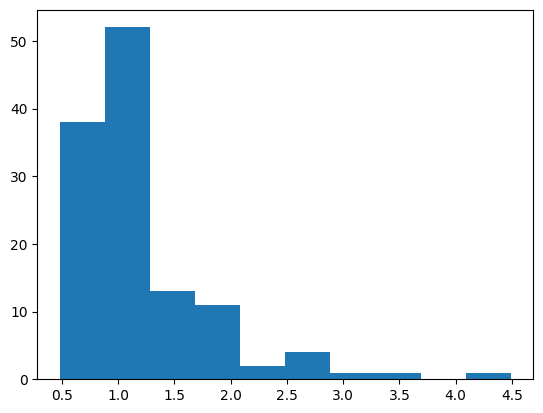

In [29]:
plt.hist(df.price,bins=10)
print(df.price.describe())

In [ ]:
df['Year'].value_counts()

In [ ]:
price = df['price']
chicken = df['chicken lay']

# create a scatter plot
plt.scatter(chicken , price)
plt.xlabel('chicken lay')
plt.ylabel('Price')
plt.title('Price vs. Chicken lay')
plt.show()

check data is stationery or not?

In [30]:
from statsmodels.tsa.stattools import adfuller
x=df['price']
result=adfuller(x)
print("ADF Stataics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

ADF Stataics  -4.600527545449679
p-value 0.00012888074714791786
critical values 72.62552585074343
fail to reject null hypothese h1 , it mean data is stationary


<Axes: >

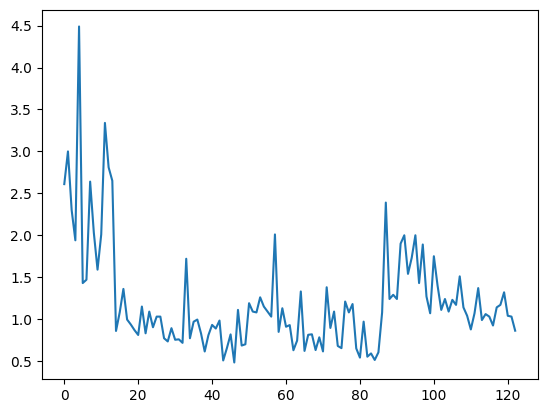

In [31]:
#Now checking data is stationary or not using graphs.
df['price'].plot()

For ARIMA forcasting we need two parameter q and q that P is  parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead.and q is the number of lagged forecast error terms in the prediction equation.now we want to calculate P and q

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['price'].iloc[1:],lags=30)
plot_pacf(df['price'].iloc[1:],lags=30)

P=3 and q =2 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(df['price'], order=(1,1,2))
result = model.fit()
df['forecast_ARIMA'] = result.predict(start = 92, end= 114, dynamic= True)  
df[['price', 'forecast_ARIMA']].plot(figsize=(8, 5))


Check how SARIMA will perform on this seasonal data.

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['price'],order=(2,1,2),seasonal_order=(2,1,2,6))
result=model.fit()

In [ ]:
df['forcast_SARIMA_1']=result.predict(start=99, end=112, dynamic=True)
df[['price','forcast_SARIMA_1']].plot(figsize=(20, 5))

SARIMA model is working well. because data is seasonal.

So, we are try to predict future forecasting using SARIMA model.



In [ ]:

import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("1969-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future_prediction = pd.DataFrame(index=date_list, columns= df.columns)
future = pd.DataFrame(columns=df.columns) 
df= pd.concat([df, future])

**Predict future forecasting using SARIMA**

In [ ]:
df['future_prediction']=result.predict(start=113, end=130, dynamic=True)
df[['price','future_prediction']].plot(figsize=(10, 6))
plt.grid(True)

In [ ]:
df['future_prediction'] = result.predict(start=113, end=130, dynamic=True)
df[['price', 'future_prediction']].iloc[-20:].plot(figsize=(10, 6))